Temporal series, multiseries plotting, and small multiples
======

This notebook is about:
- loading a dataset with temporal data
- manipulating the dataset
- quick exploration of the dataset
- more polished represenation
- use of small multiples

Tools used include Pandas and Seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import patheffects
import datetime

#### Dataset loading

In [44]:
flights = sns.load_dataset("flights")
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


The data are in so-called "long form":
- each variable&emsp;&emsp;<->&emsp;column
- each observation&emsp;<->&emsp;row

#### Dataset processing

Store the available years and months in arrays for potential later use

In [3]:
years = flights.year.unique()

#years.sort()

years

array([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960], dtype=int64)

In [4]:
months = flights.month.unique()

print(months)

[month for month in months]

['Jan', 'Feb', 'Mar', 'Apr', 'May', ..., 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Length: 12
Categories (12, object): ['Jan', 'Feb', 'Mar', 'Apr', ..., 'Sep', 'Oct', 'Nov', 'Dec']


['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

WARNING: the month categories are already correctly ordered. It might not always be the case. We need to handle it with more care in general.

We pivot with sum to obtain annual flights

In [5]:
flights.pivot_table(index = "year", values = "passengers", aggfunc = "sum")

,passengers
year,
1949,1520
1950,1676
1951,2042
1952,2364
1953,2700
1954,2867
1955,3408
1956,3939
1957,4421


We can pivot to get monthly series by year

In [6]:
flights.pivot_table(index = "month", columns = "year", values = "passengers")

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


The data are in so-called "wide form":
- variables &emsp;&emsp;<->&emsp; both columns and rows
- observation &emsp;<->&emsp;entry in the table

Each column is a series

We can create a date column

In [7]:
# create column with date string "YEAR-MONTH"
flights["date"] = flights["year"].astype(str) + "-" + flights["month"].astype(str)
# convert to datetime
flights["date"] = pd.to_datetime(flights["date"])
# set as index
flights = flights.set_index("date")

In [8]:
# the date has automatically been set to be the first of the month
flights.head()

,year,month,passengers
date,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


#### Plotting

Plot of the yearly total after pivoting

[ uses Pandas chaining: dataframe methods often return dataframes that can be further processed with other methods, including plotting methods ]

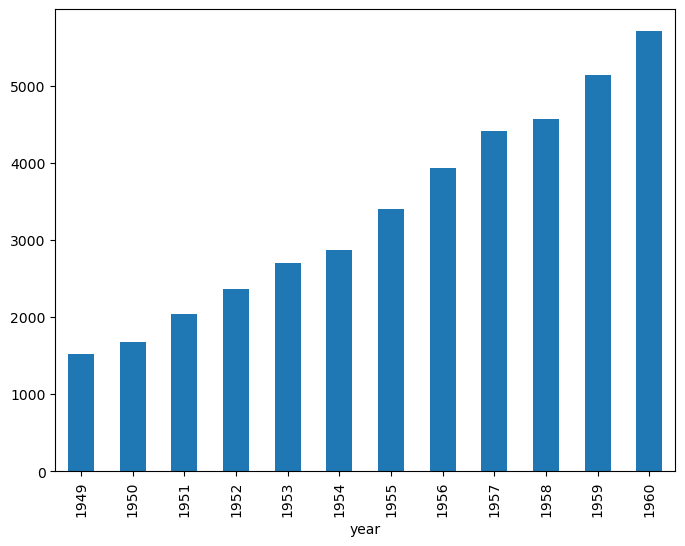

In [10]:
ax = (
    flights
    # pivot the data
    .pivot_table(index = "year", values = "passengers", aggfunc = "sum")
    # plot the data
    .plot.bar(legend = False, figsize = (8, 6))
)

# further customization is possible using the ax object

Pandas *Series* with monthly flights

In [11]:
flights["passengers"]

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: passengers, Length: 144, dtype: int64

Plot the full monthly data. The horizontal axis is continuous rather than categorical.

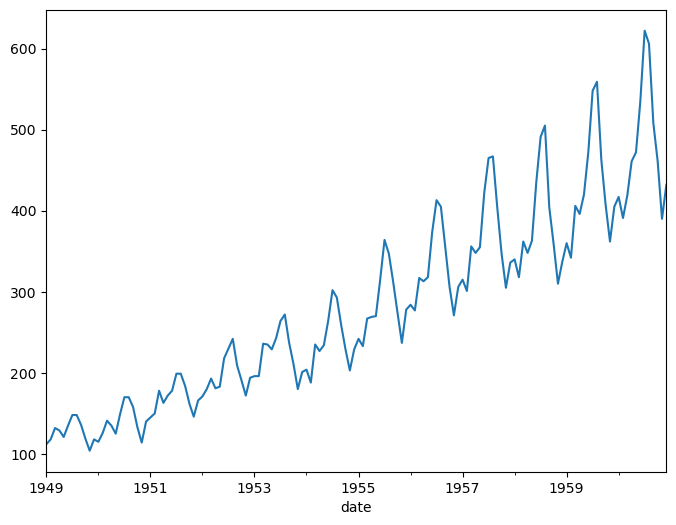

In [12]:
ax = flights["passengers"].plot(legend = False, figsize = (8, 6))

WARNING: for bar plots, Pandas treats the date index as categorical, leading to unintended consequences

Besides not handling nicely the ticks and the tick labels...

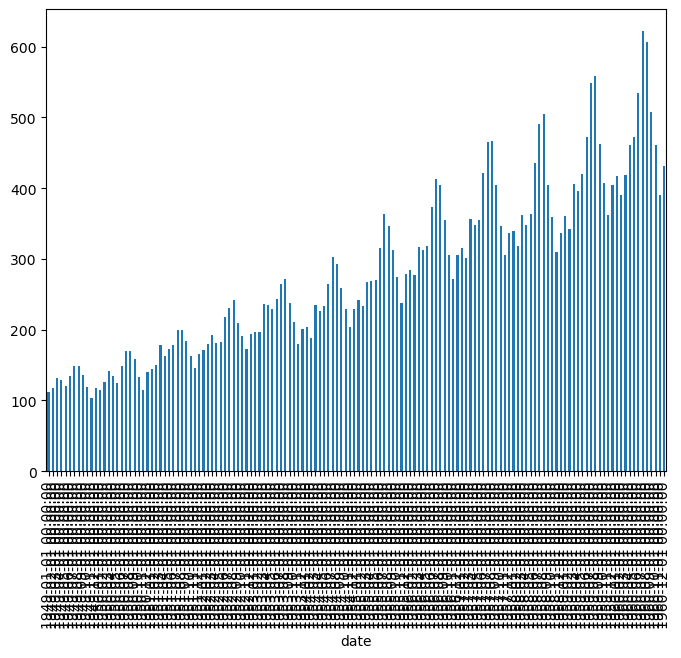

In [13]:
ax = flights["passengers"].plot.bar(legend = False, figsize = (8, 6))

... the notion of time is lost

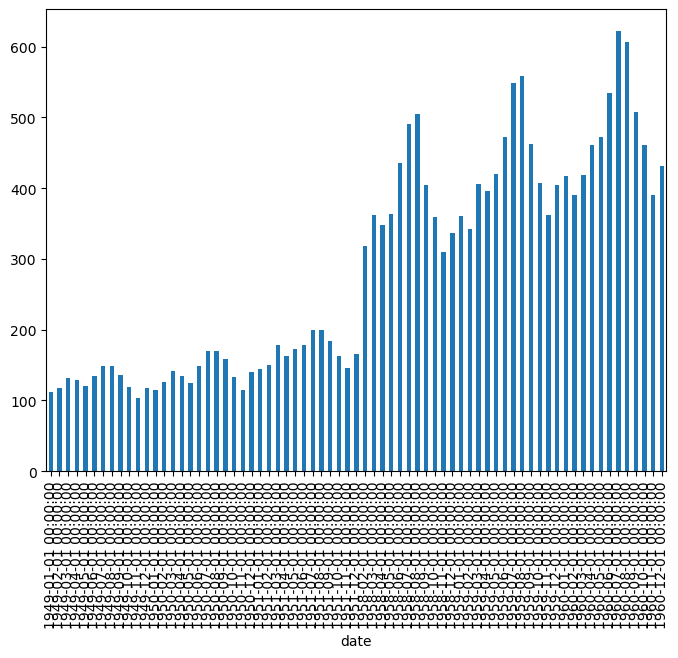

In [31]:
flights_to_plot = (
    flights["passengers"]
    .loc[
        (flights.index<datetime.datetime(1952,1,1))
        | (flights.index>datetime.datetime(1958,1,1))
    ]
)

ax = flights_to_plot.plot.bar(legend = False, figsize = (8, 6))


Matplotlib handles the horizontal dates better for a bar plot dealing with a temporal x-axis

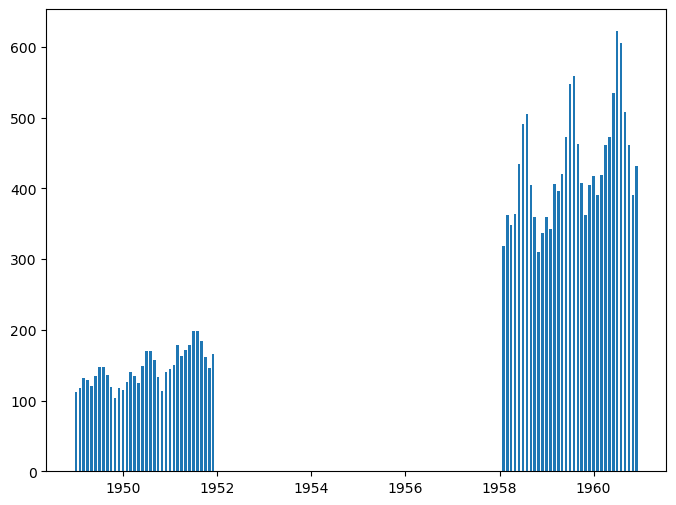

In [15]:
plt.bar(
    flights_to_plot.index,
    flights_to_plot.values,
    width = datetime.timedelta(21),
    )

plt.gcf().set_size_inches(8, 6)

Plotting monthly series by year ("wrapping" the whole temporal series)

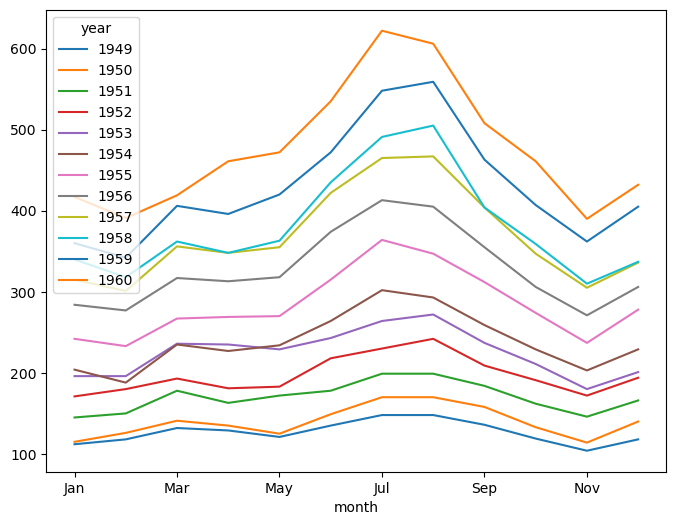

In [16]:
ax = (
    flights
    .pivot_table(index = "month", columns = "year", values = "passengers")
    .plot(figsize = (8, 6))
)

We can set the vertical scale to be logarithmic.

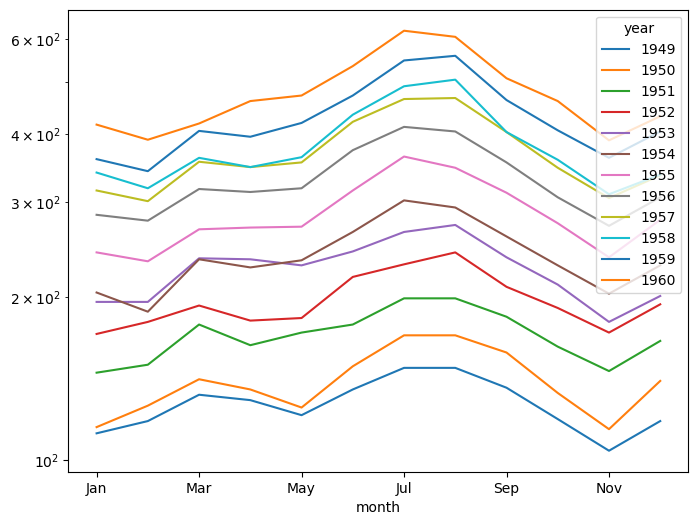

In [34]:
ax = (
    flights
    .pivot_table(index = "month", columns = "year", values = "passengers")
    .plot(
        figsize = (8, 6),
        # sets the vertical scale to be logarithmic
        logy = True
    )
)

The resulting plot suggests that passengers in each month roughly grew by the same percentage, year over year, i.e.,
$$
f(year,month)\approx a_{month} \cdot g(year)
$$
as
$$
\log(f(year,month))~\log(a_{month} \cdot g(year)) = \log(a_{month})+\log(g(year))
$$
in which case the plots of the monthly data by year appear as ~the same curve, shifted year after year in the log plot

#### **EXERCISE**:
Create a joint plot of each month's time series over years

#### Polishing the plot

Polishing the plot with Pandas

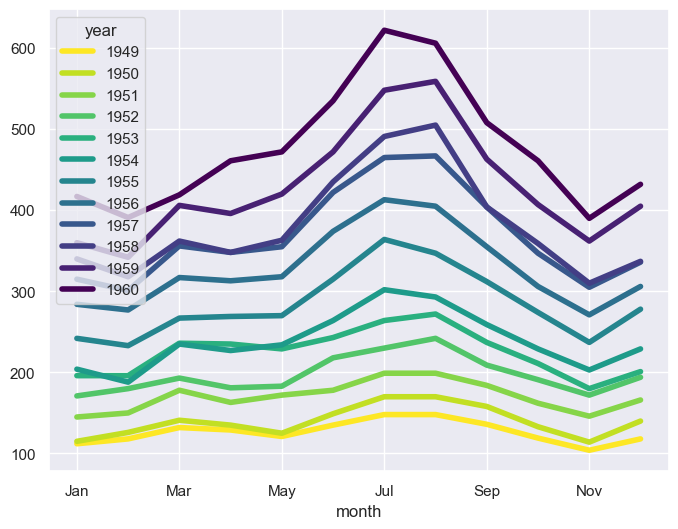

In [75]:
ax = (
    flights
    .pivot_table(index = "month", columns = "year", values = "passengers")
    .plot(
        figsize = (8, 6),
        # use a colormap to color the lines sequentially
        cmap = "viridis_r",
        # thicker lines
        lw = 4
    )
)

**QUESTION**: what is "wrong" with the legend?

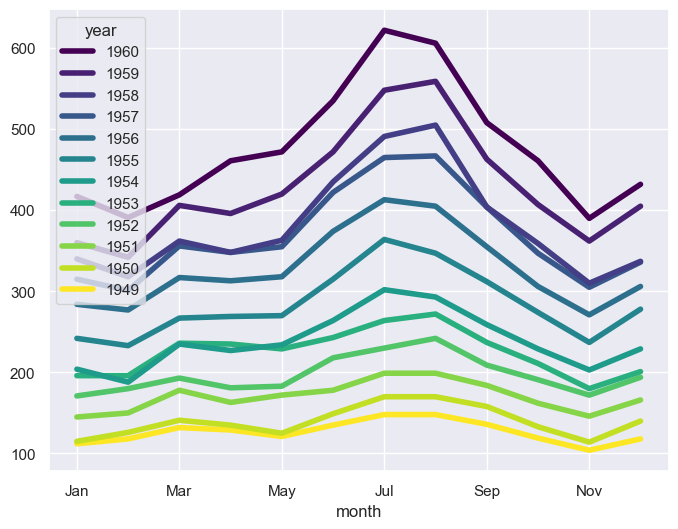

In [66]:
ax = (
    flights
    .pivot_table(index = "month", columns = "year", values = "passengers")
    .plot(
        figsize = (8, 6),
        cmap = "viridis_r",
        lw = 4,
        # Pandas allows to reverse the order of the legend
        legend = "reverse"
    )
)

Plotting with Seaborn

Seaborn allows us to worry less about the structure of the data, focusing on the conceptual relation

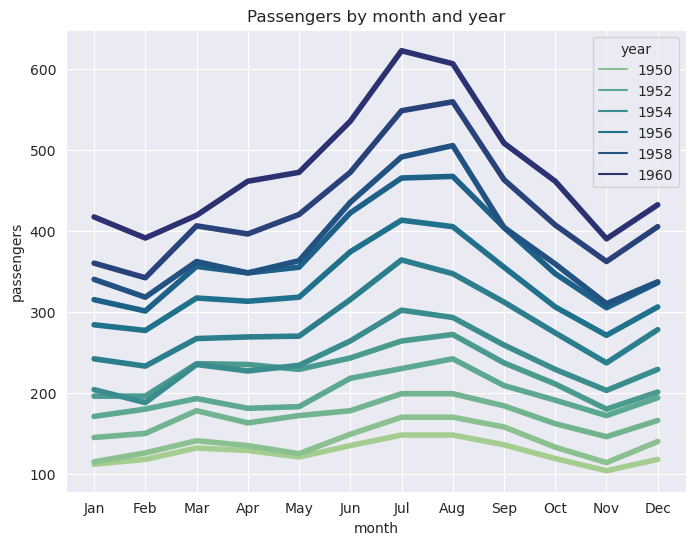

In [21]:
fig = plt.figure(figsize = (8, 6))

# we use the "with" statement to create a context for the use of a seaborn style, not affecting the rest of the notebook

with sns.axes_style("darkgrid"):

    ax = fig.add_subplot()

    g = sns.lineplot(
        data = flights,
        # we do not worry about the format of the dataset
        # we just tell seaborn which variables to use for what
        x="month", y="passengers", hue="year",
        palette="crest", linewidth=4, ax = ax
    )

    g.set_title("Passengers by month and year")

Variations on the use of the legend and labels

In [146]:
my_labelling = "auto"# options: "auto", "my_legend", "labels"

# We choose where to put the labels, if applicable.
# Labels will be positioned in between these two adjacent months
months_for_Labels = ["Jul","Aug"]
# we choose the frequency of the labels, if applicable
label_frequency = 1


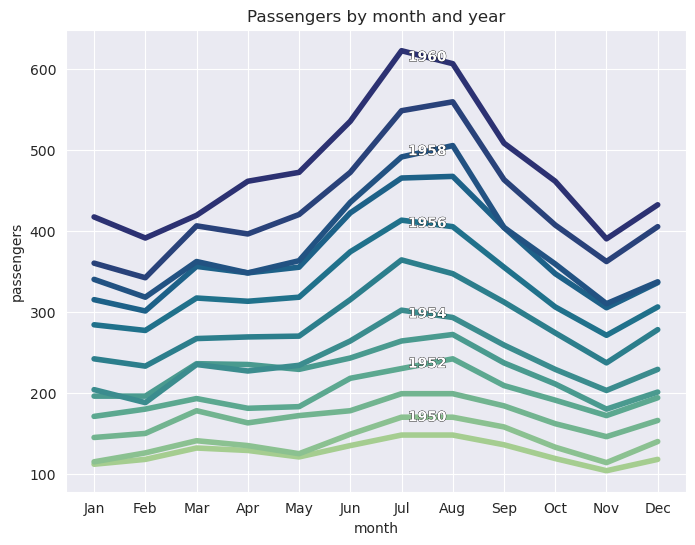

In [145]:
fig = plt.figure(figsize = (8, 6))

with sns.axes_style("darkgrid"):

    ax = fig.add_subplot()

    g = sns.lineplot(
        data=flights,
        x="month", y="passengers", hue="year",
        palette="crest", linewidth=4, ax = ax
    )

    g.set_title("Passengers by month and year")

    # code below is to control how the year information is displayed

    match my_labelling:

        case "auto":
            
            pass
        
        case "my_legend":

            handles, labels = g.get_legend_handles_labels()

            myLeg = g.legend(handles = reversed(handles), labels = reversed(labels), title = "Year")

            # set the linewidth of each legend object
            for legobj in myLeg.legendHandles:

                legobj.set_linewidth(4.0)

        case "labels":

            g.get_legend().remove()

            # we calculate the x position of the labels
            # we use the index of the months_for_Labels list and the fact that
            # categorical plotting uses integer positions for the x axis
            x_label = list(months).index(months_for_Labels[0]) + 0.5
            # we calculate the y position of the labels as average of the two months
            y_labels = flights[flights.month.isin(months_for_Labels)].groupby("year").mean()

            for year in years[label_frequency-1::label_frequency]:

                ax.text(
                    x_label,
                    y_labels.loc[year, "passengers"],
                    f"{year}",
                    ha = "center",
                    va = "center",
                    color = "white", fontweight = "bold",
                    path_effects = [patheffects.withStroke(linewidth=0.5, foreground='black')],
                )


#### **EXERCISE**:
- Why is putting the labels in between July and August preferable?
- Why we may choose to indicate one label every two rather than each and every label?

#### Small multiples

Small multiples represent each series independently in its own subplot.

With Pandas

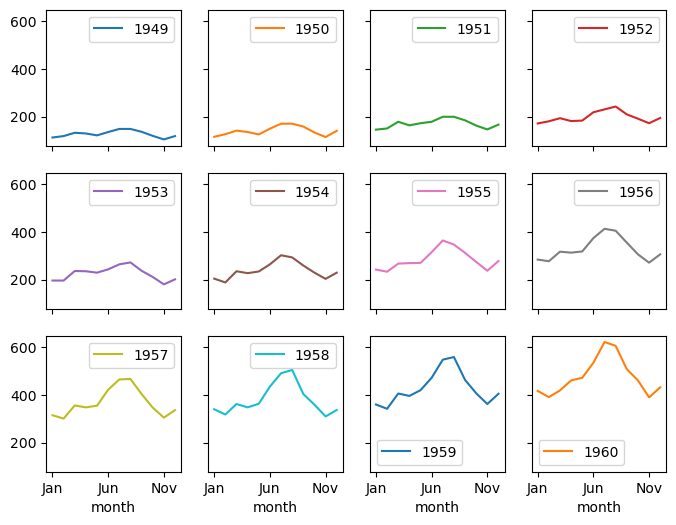

In [141]:
axes = flights.pivot_table(
    index = "month", columns = "year", values = "passengers"
    ).plot(
        layout = (3,4),
        subplots = True,
        figsize = (8, 6),
        sharex = True,
        sharey = True,
    )

With Seaborn and some polishing (slight modification of the example at https://seaborn.pydata.org/examples/timeseries_facets.html )

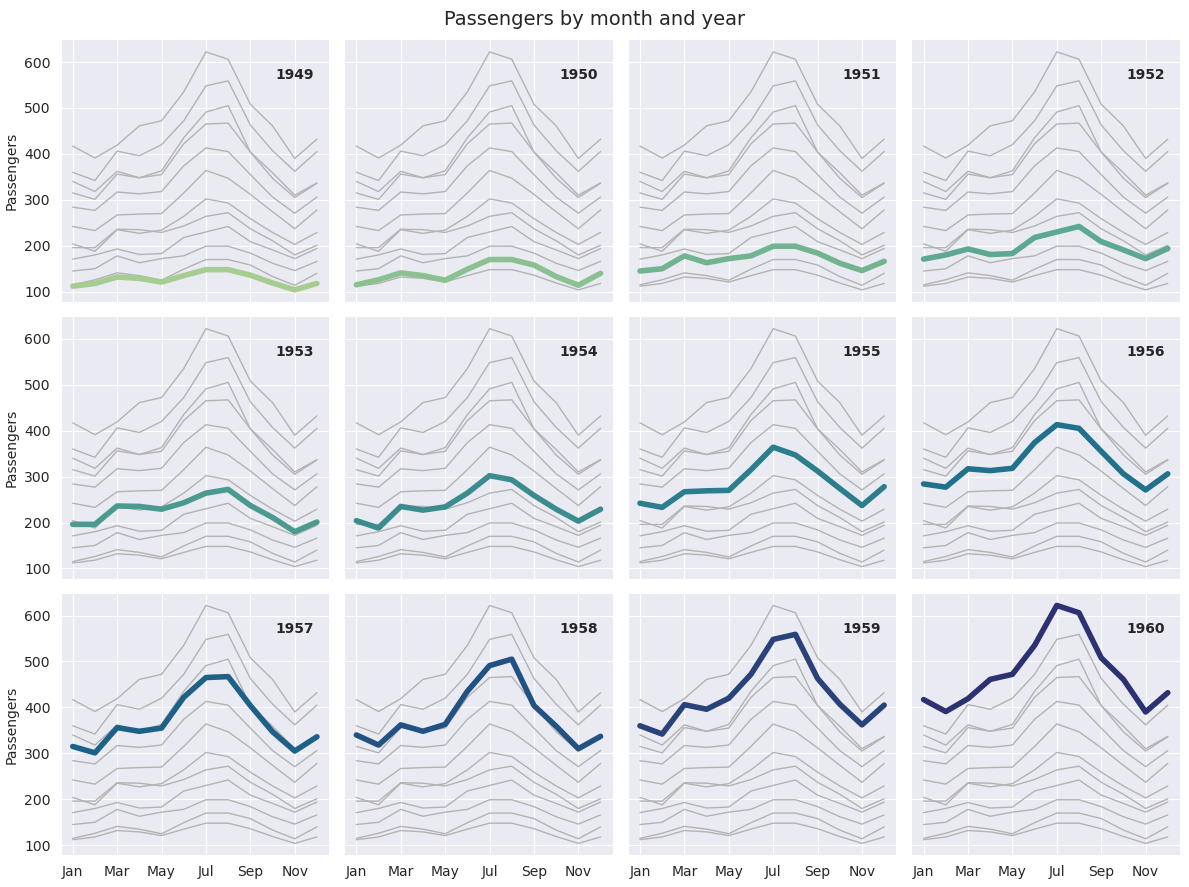

In [43]:
# we use the "with" statement to create a context for the use of a seaborn style, not affecting the rest of the notebook

with sns.axes_style("darkgrid"):

    # Plot each year's time series in its own facet
    g = sns.relplot(
        data=flights,
        x="month", y="passengers", col="year", hue="year",
        kind="line", palette="crest", linewidth=4, zorder=5,
        col_wrap=4, height=3, aspect=1, legend=False,
    )

    # Iterate over each subplot to customize further
    for year, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

        # Plot every year's time series in the background
        sns.lineplot(
            data=flights, x="month", y="passengers", units="year",
            estimator=None, color=".7", linewidth=1, ax=ax,
        )

    # Reduce the frequency of the x axis ticks
    ax.set_xticks(ax.get_xticks()[::2])

    # Tweak the supporting aspects of the plot

    # title for the figure
    g.fig.suptitle("Passengers by month and year", fontsize=14)
    # remove automatic titles per subplot/facet
    g.set_titles("")
    g.set_axis_labels("", "Passengers")
    g.tight_layout()

### **EXERCISE**:
- Create a similar Seaborn small-multiple plot where each *month* has its own facet/subplot, with passegers plotted as function of the year
- Reposition the "titles" so that they do not overlap with the plotted series
- Is there any issue with the horizontal tick labels? 

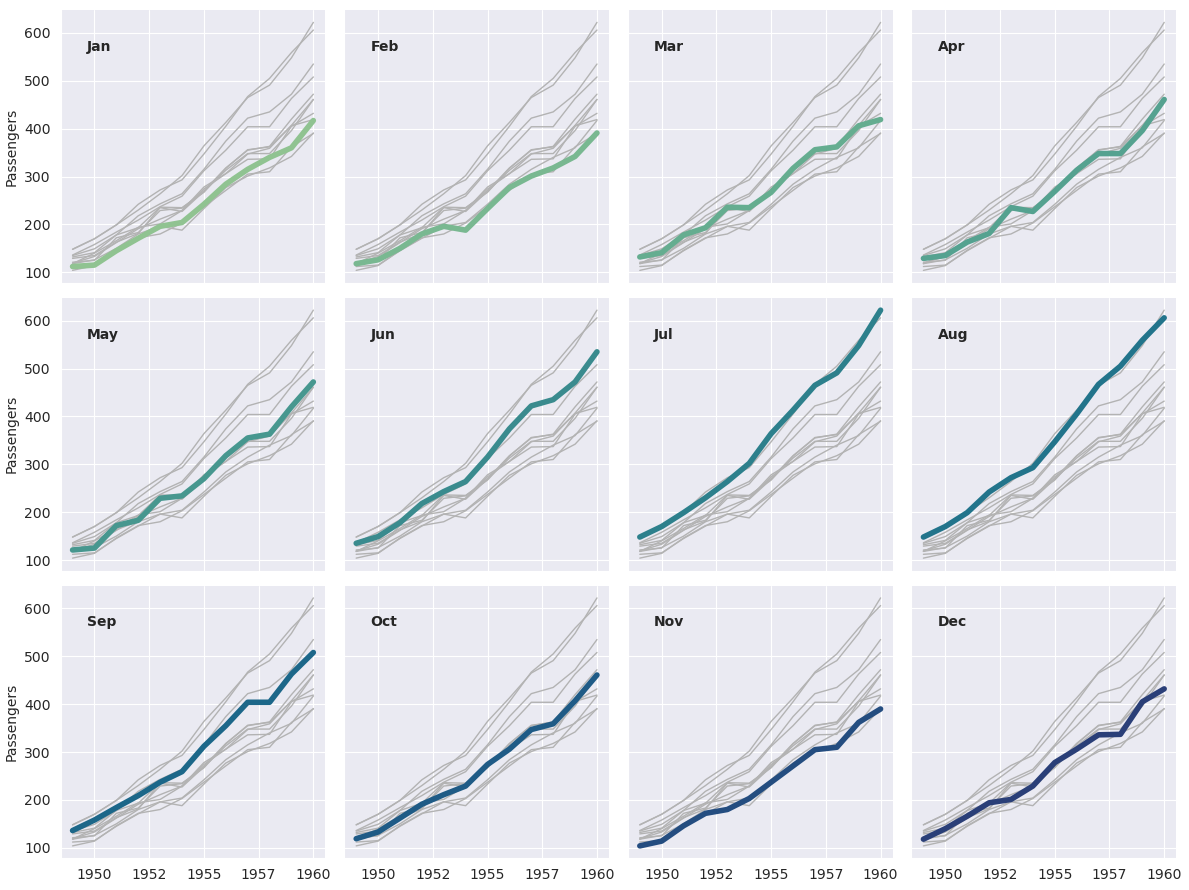

In [38]:
myNcols = 4

# we use the "with" statement to create a context for the use of a seaborn style, not affecting the rest of the notebook

with sns.axes_style("darkgrid"):

    # Plot each year's time series in its own facet
    g = sns.relplot(
        data=flights,
        x="year", y="passengers", col="month", hue = "month",
        kind="line", palette="crest", linewidth=4, zorder=5,
        col_wrap = myNcols, height=3, aspect=1, legend=False
    )

    # Iterate over each subplot to customize further
    for month, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.1, .85, month, transform=ax.transAxes, fontweight="bold", zorder = 10)

        # Plot every year's time series in the background
        sns.lineplot(
            data=flights, x="year", y="passengers", units="month",
            estimator=None, color=".7", linewidth=1, ax=ax
        )

    # g.set(yscale = "log")

    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x)}"))

    # Tweak the supporting aspects of the plot

    g.set_titles("")
    g.set_axis_labels("", "Passengers")

    g.tight_layout()
